# Validation of effective Hamiltonian extraction

In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import h5py
import rqutils.paulis as paulis
from rqutils.qprint import qprint
from rqutils.math import matrix_exp, matrix_angle
import qudit_sim

qudit_sim.config.jax_devices = [0, 1]

try:
    os.makedirs('heff_validation')
except OSError:
    pass

## Single qubit resonant drive

In [2]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')

In [3]:
hgen.add_drive('q0', frequency=100., amplitude=0.1)
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [4]:
components = qudit_sim.apps.find_heff(hgen, 'q0', frequency=100., amplitude=0.1, cycles=100., save_result_to='heff_validation/single_qubit_resonant', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 1601 time points from 0.000e+00 to 1.257e+01
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 0.371951 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/single_qubit_resonant.h5
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 124 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets that satisfy the eigenvalues tolerance.


In [5]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

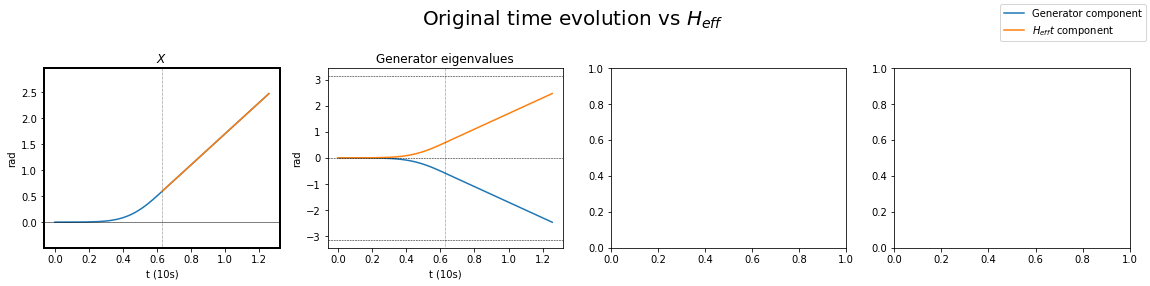

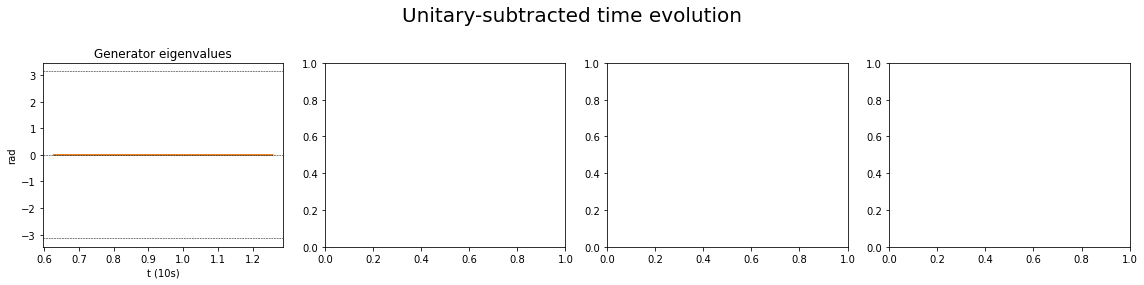

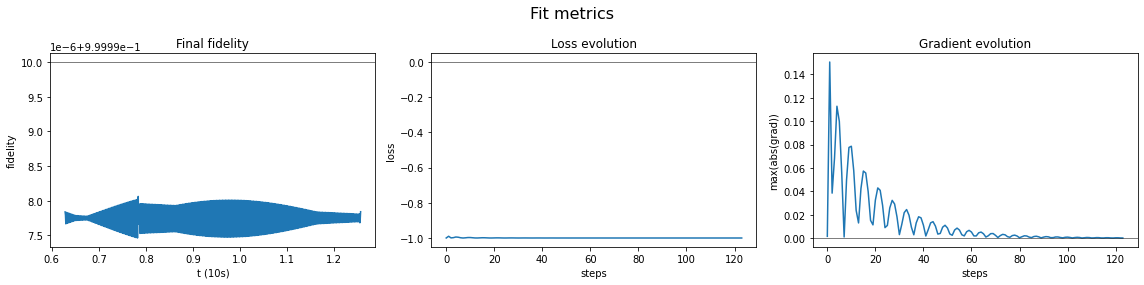

In [6]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/single_qubit_resonant.h5');

## Single qubit off-resonant drive

When the drive is slightly off-resonant, it becomes hard to define an effective Hamiltonian, but there is some linear dependency that can be extracted.

In [7]:
hgen = qudit_sim.HamiltonianBuilder(2)
qubit_freq = 100.
drive_freq = 100.1
drive_amp = 0.1
hgen.add_qudit(qubit_frequency=qubit_freq, anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
components = qudit_sim.apps.find_heff(hgen,
                                      qudit='q0',
                                      frequency=drive_freq,
                                      amplitude=drive_amp,
                                      eigvals_tol=np.pi,
                                      save_result_to='heff_validation/single_qubit_offresonant',
                                      log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 8801 time points from 0.000e+00 to 6.905e+01
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 2.130526 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/single_qubit_offresonant.h5
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 217 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets that satisfy the eigenvalues tolerance.


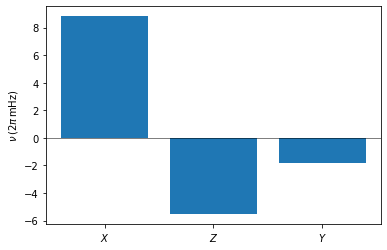

In [8]:
qudit_sim.visualization.plot_components(components, threshold=0.001);

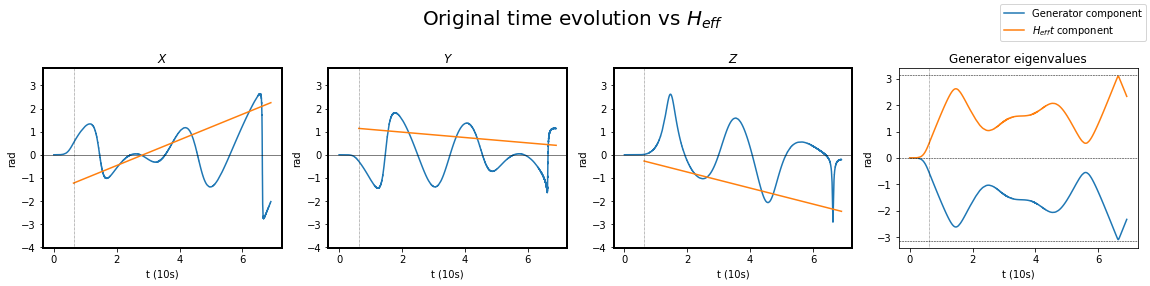

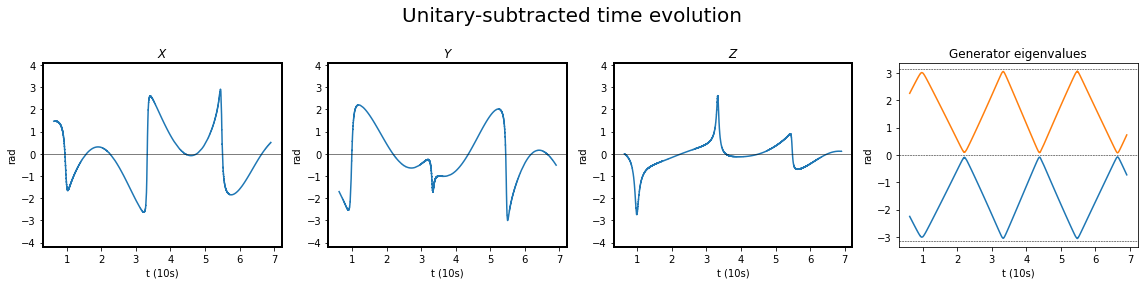

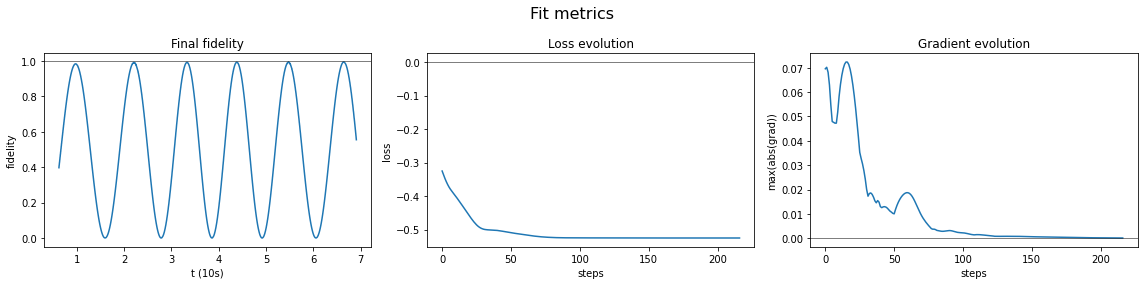

In [9]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/single_qubit_offresonant.h5');

## Single qutrit qubit-resonant drive, qubit $H_{\mathrm{eff}}$ extraction

In [10]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')

In [11]:
hgen.add_drive('q0', frequency=100., amplitude=0.1)
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [12]:
components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=100., amplitude=0.1, save_result_to='heff_validation/single_qutrit_resonant', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 8801 time points from 0.000e+00 to 6.912e+01
INFO:qudit_sim.pulse_sim:Hamiltonian with 3 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 2.170488 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/single_qutrit_resonant.h5
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 132 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets that satisfy the eigenvalues tolerance.


In [13]:
qudit_sim.visualization.print_components(components, threshold=0.)

<IPython.core.display.Latex object>

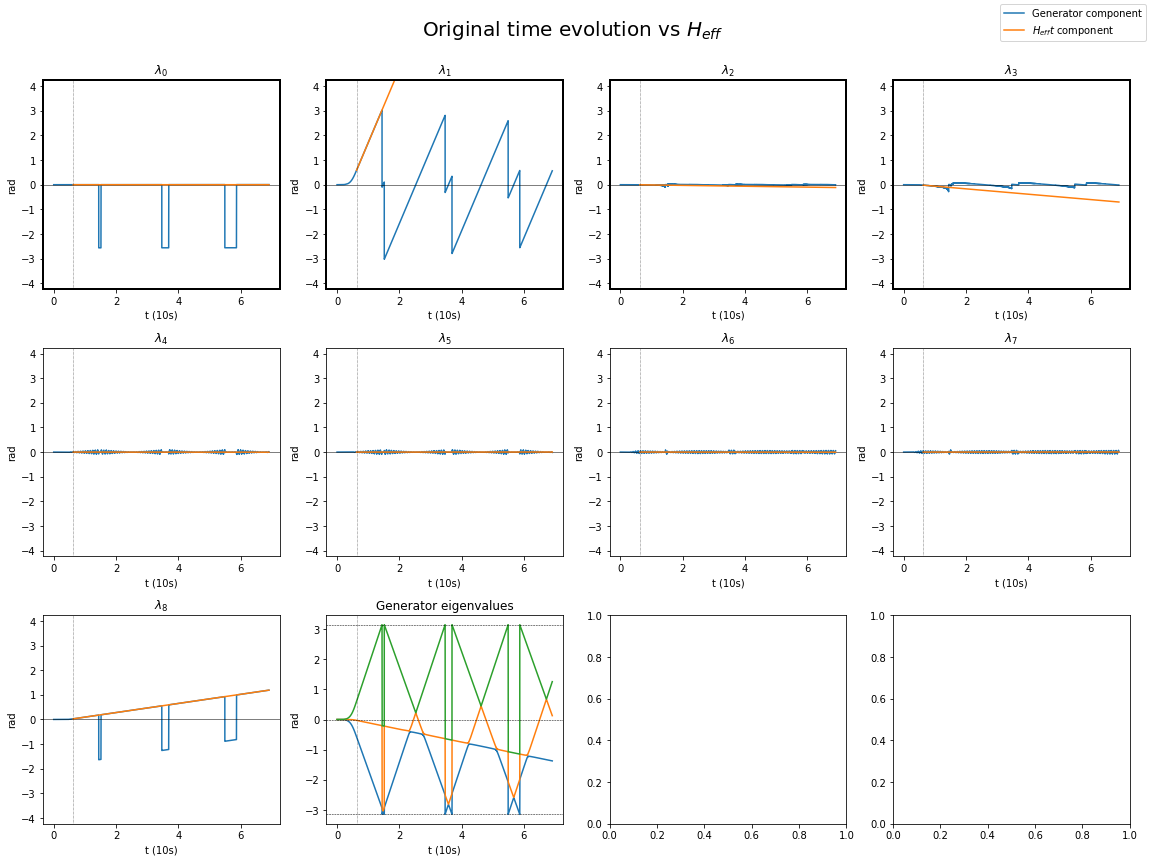

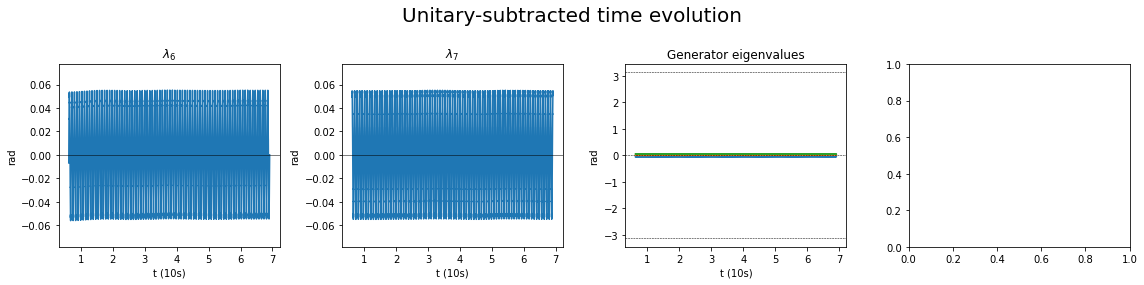

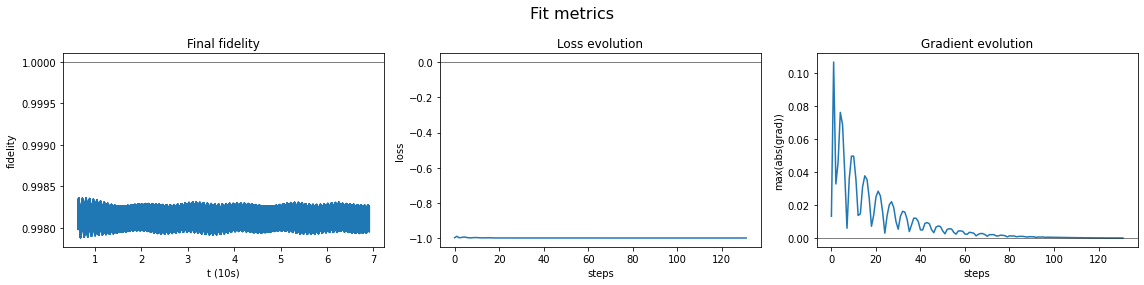

In [14]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/single_qutrit_resonant.h5');

## Two qubit cross resonance, no crosstalk

In [15]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)
drive_frequency = hgen.dressed_frequencies('q1')[0]

In [16]:
hgen.add_drive('q0', frequency=drive_frequency, amplitude=0.2)
qudit_sim.visualization.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [17]:
components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency, amplitude=0.2, save_result_to='heff_validation/cross_resonance', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 2.273571 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/cross_resonance.h5
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 114 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets that satisfy the eigenvalues tolerance.


In [18]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

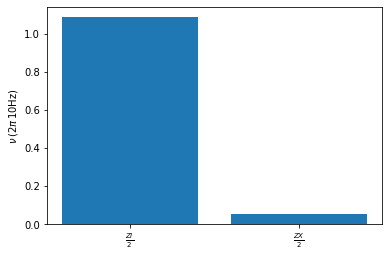

In [19]:
qudit_sim.visualization.plot_components(components);

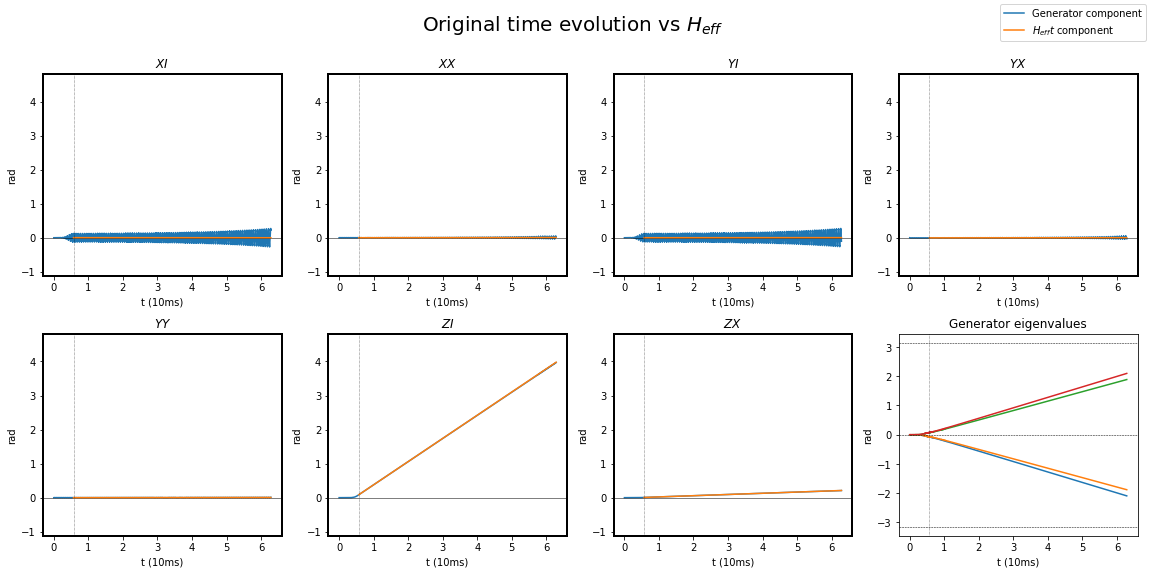

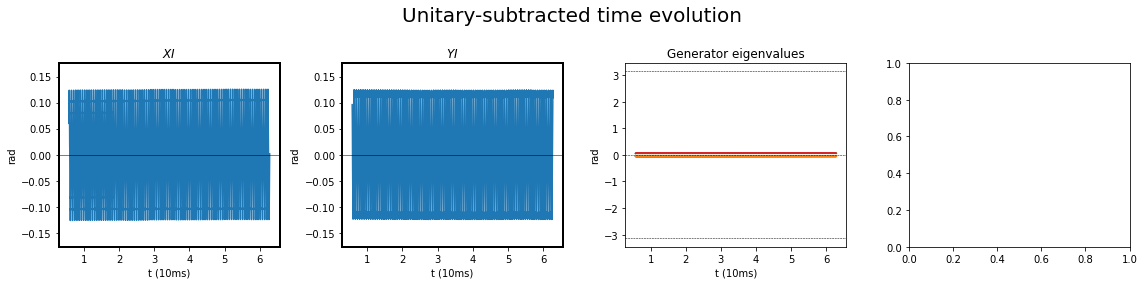

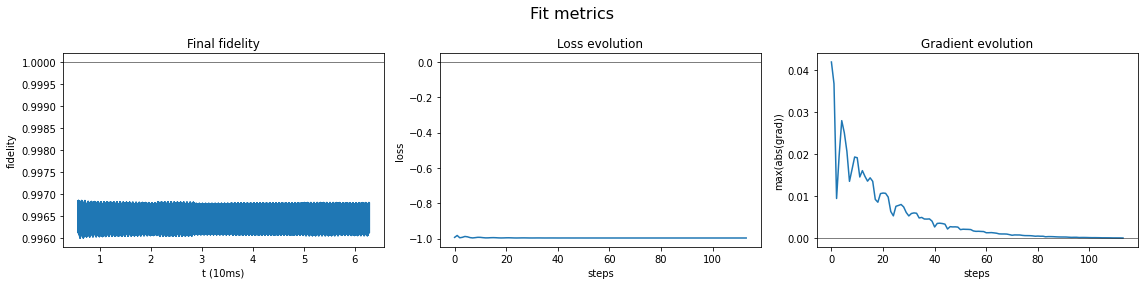

In [20]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/cross_resonance.h5');

## Cross resonance amplitude scan

In [21]:
amplitudes = np.linspace(0., 0.25, 10)

hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)
drive_frequency = hgen.dressed_frequencies('q1')[0]

components_list = qudit_sim.apps.find_heff(hgen,
                                           qudit='q0',
                                           frequency=drive_frequency,
                                           amplitude=amplitudes,
                                           eigvals_tol=0.3,
                                           save_result_to='heff_validation/cr_amplitude_scan',
                                           log_level=logging.INFO)

INFO:qudit_sim.parallel:Executing _run_single in 10 parallel (max 64 simultaneous) processes..
INFO:qudit_sim.pulse_sim.0:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim.1:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim.0:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.2:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim.1:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.3:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim.2:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.4:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim.3:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.5:Using 8801 time points from 0.000e+00 to 6.283e-02
INFO:qudit_sim.pulse_sim.4:Hamiltonian with 2 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.6:Using

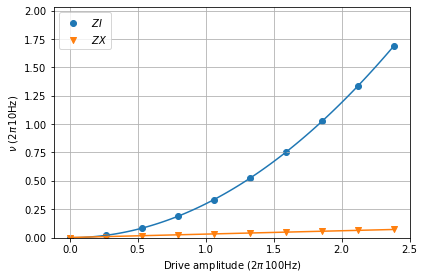

In [22]:
physical_amplitudes = amplitudes * hgen.qudit_params('q0').drive_amplitude
fig, coefficients, indices, amp_scale, compo_scale = qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list)

In [23]:
qudit_sim.visualization.print_amplitude_scan(coefficients, indices, amp_scale, compo_scale)

<IPython.core.display.Latex object>

## Two qutrit no drive

Statically coupled qudits feature "always-on" diagonal effective Hamiltonian because of the dressing of energy levels.
Here we use a two-qutrit system with an unrealistically large coupling to illustrate this point.

In [24]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 3000.)

In [25]:
# Pass a null tuple to qudit, frequency, and amplitude to run a no-drive Heff analysis
components = qudit_sim.apps.find_heff(hgen,
                                      qudit=tuple(),
                                      frequency=tuple(),
                                      amplitude=tuple(),
                                      cycles=50,
                                      eigvals_tol=np.pi,
                                      save_result_to='heff_validation/two_qutrit_hstat',
                                      log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 401 time points from 0.000e+00 to 2.835e-03
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/two_qutrit_hstat.h5
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 128 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets that satisfy the eigenvalues tolerance.


In [26]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

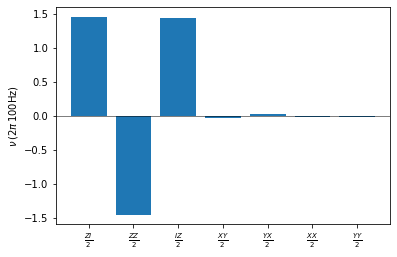

In [27]:
qudit_sim.visualization.plot_components(components);

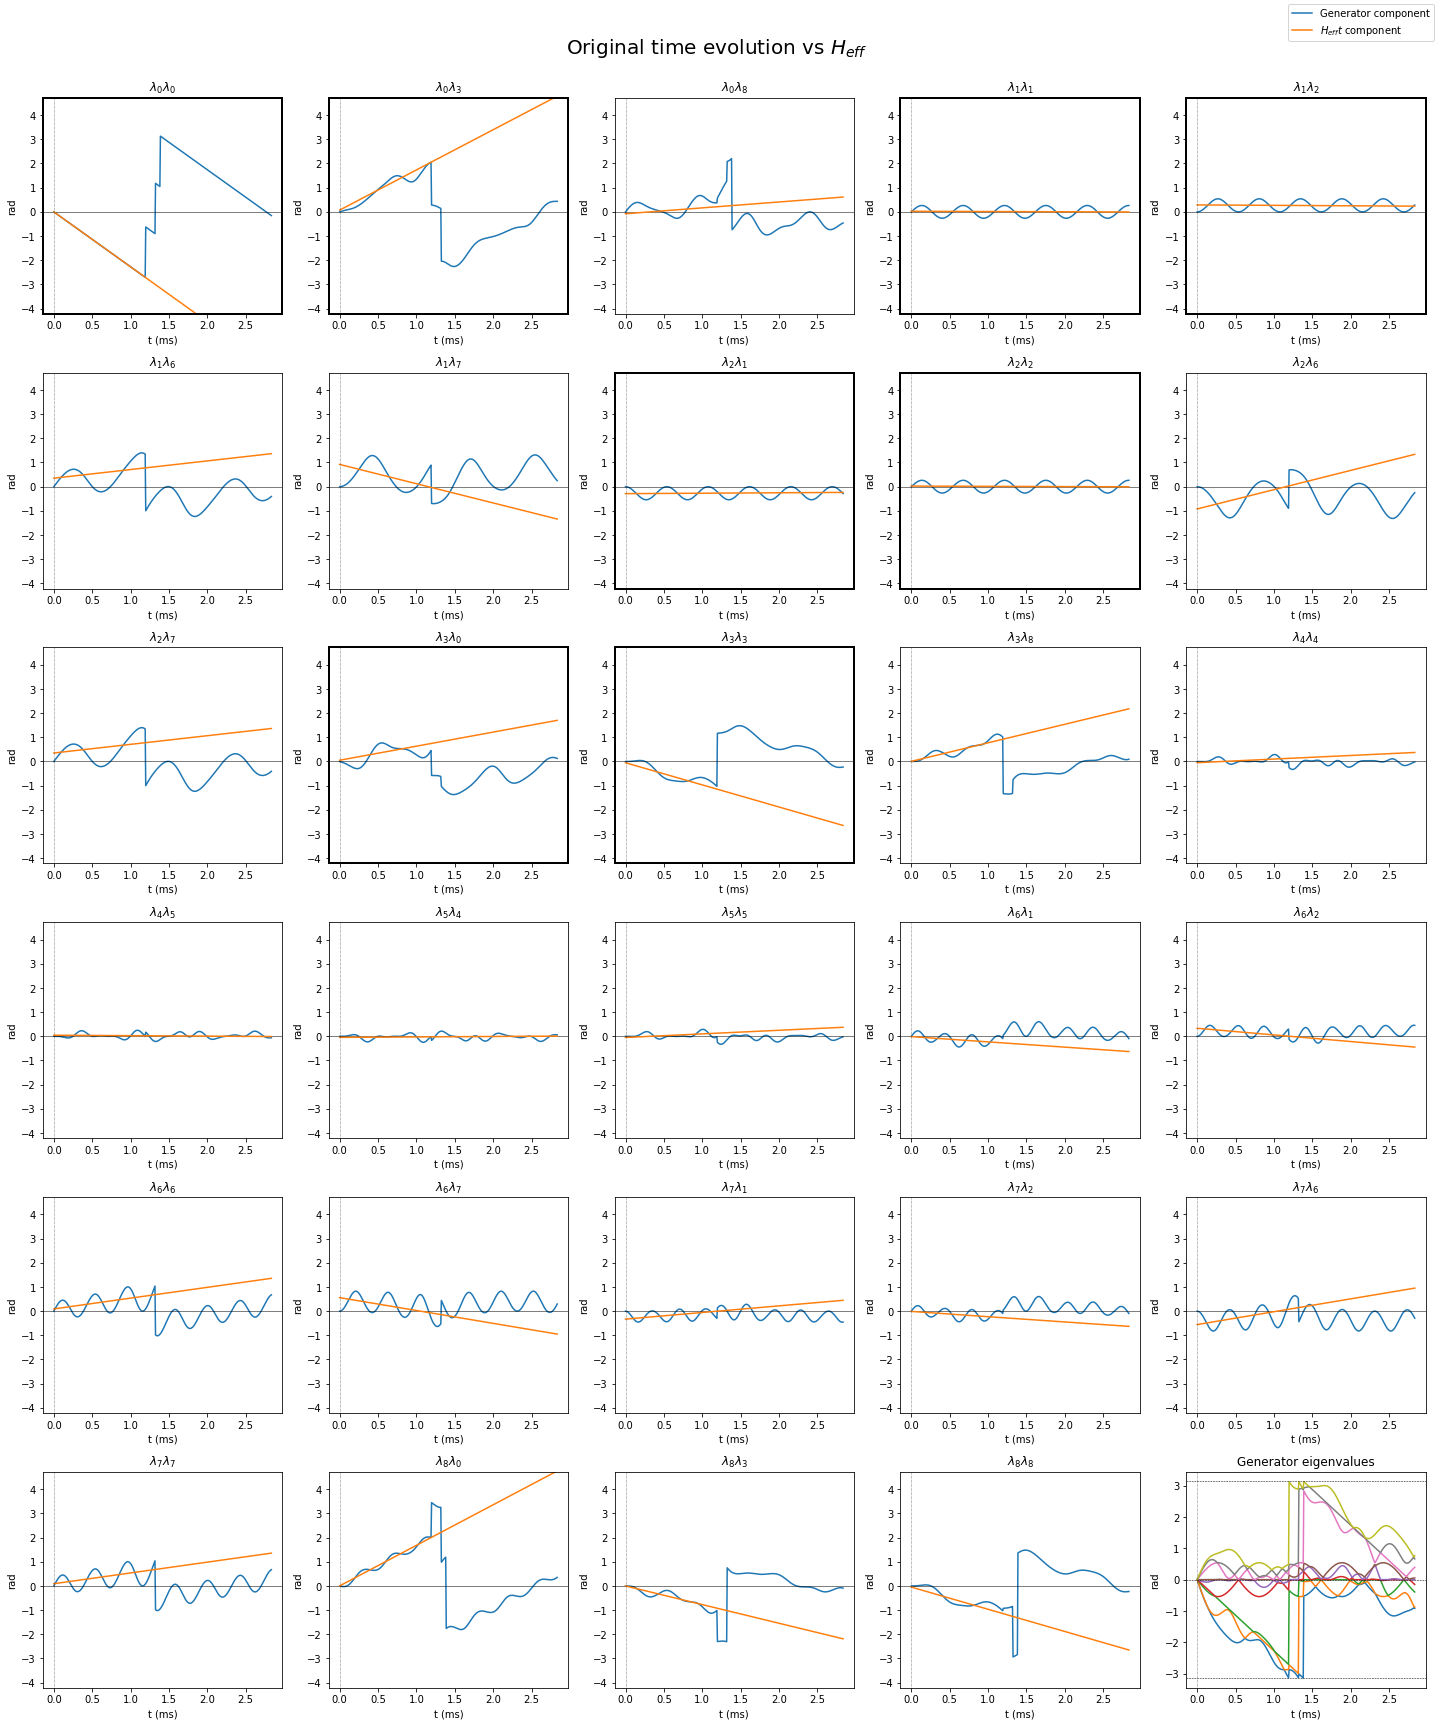

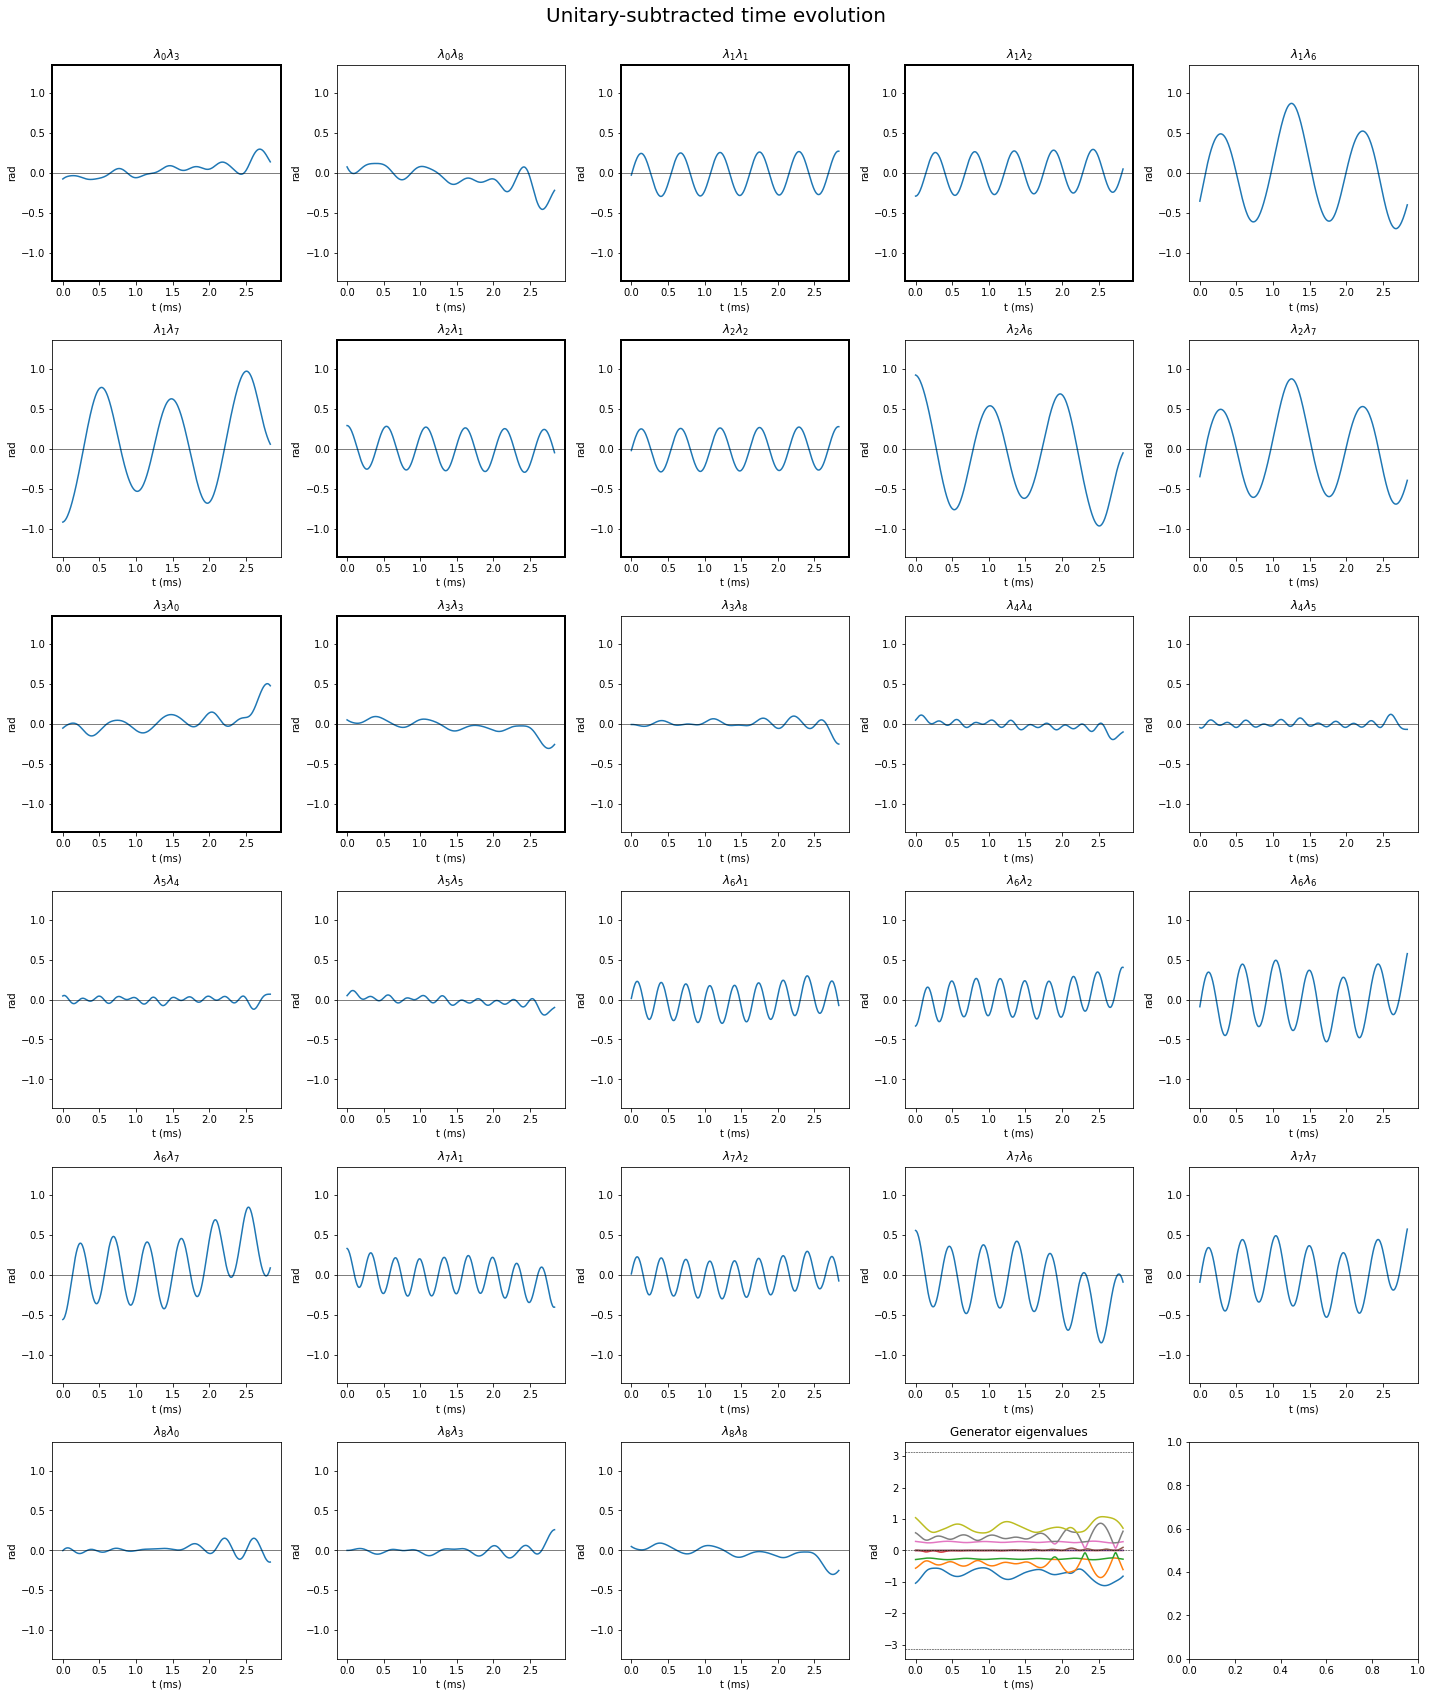

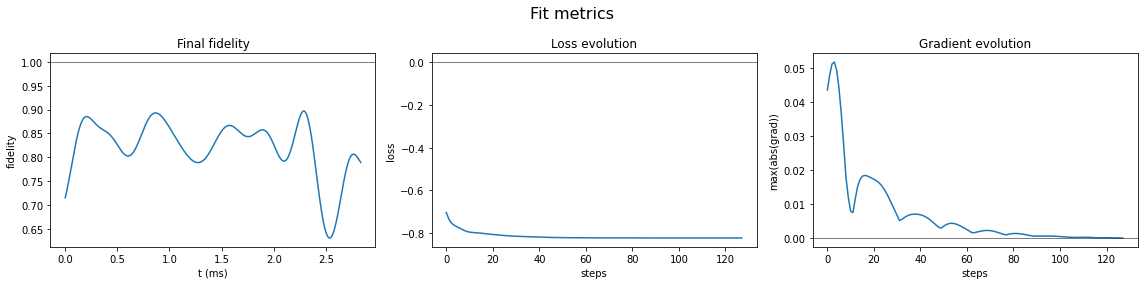

In [28]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/two_qutrit_hstat.h5');

In the qudit frame:

In [29]:
hgen.set_global_frame('qudit')
components = qudit_sim.apps.find_heff(hgen,
                                      qudit=tuple(),
                                      frequency=tuple(),
                                      amplitude=tuple(),
                                      cycles=50,
                                      eigvals_tol=np.pi,
                                      save_result_to='heff_validation/two_qutrit_hstat_quditframe')

In [30]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

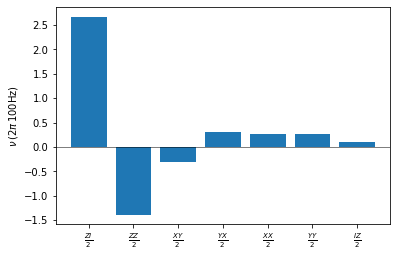

In [31]:
qudit_sim.visualization.plot_components(components);

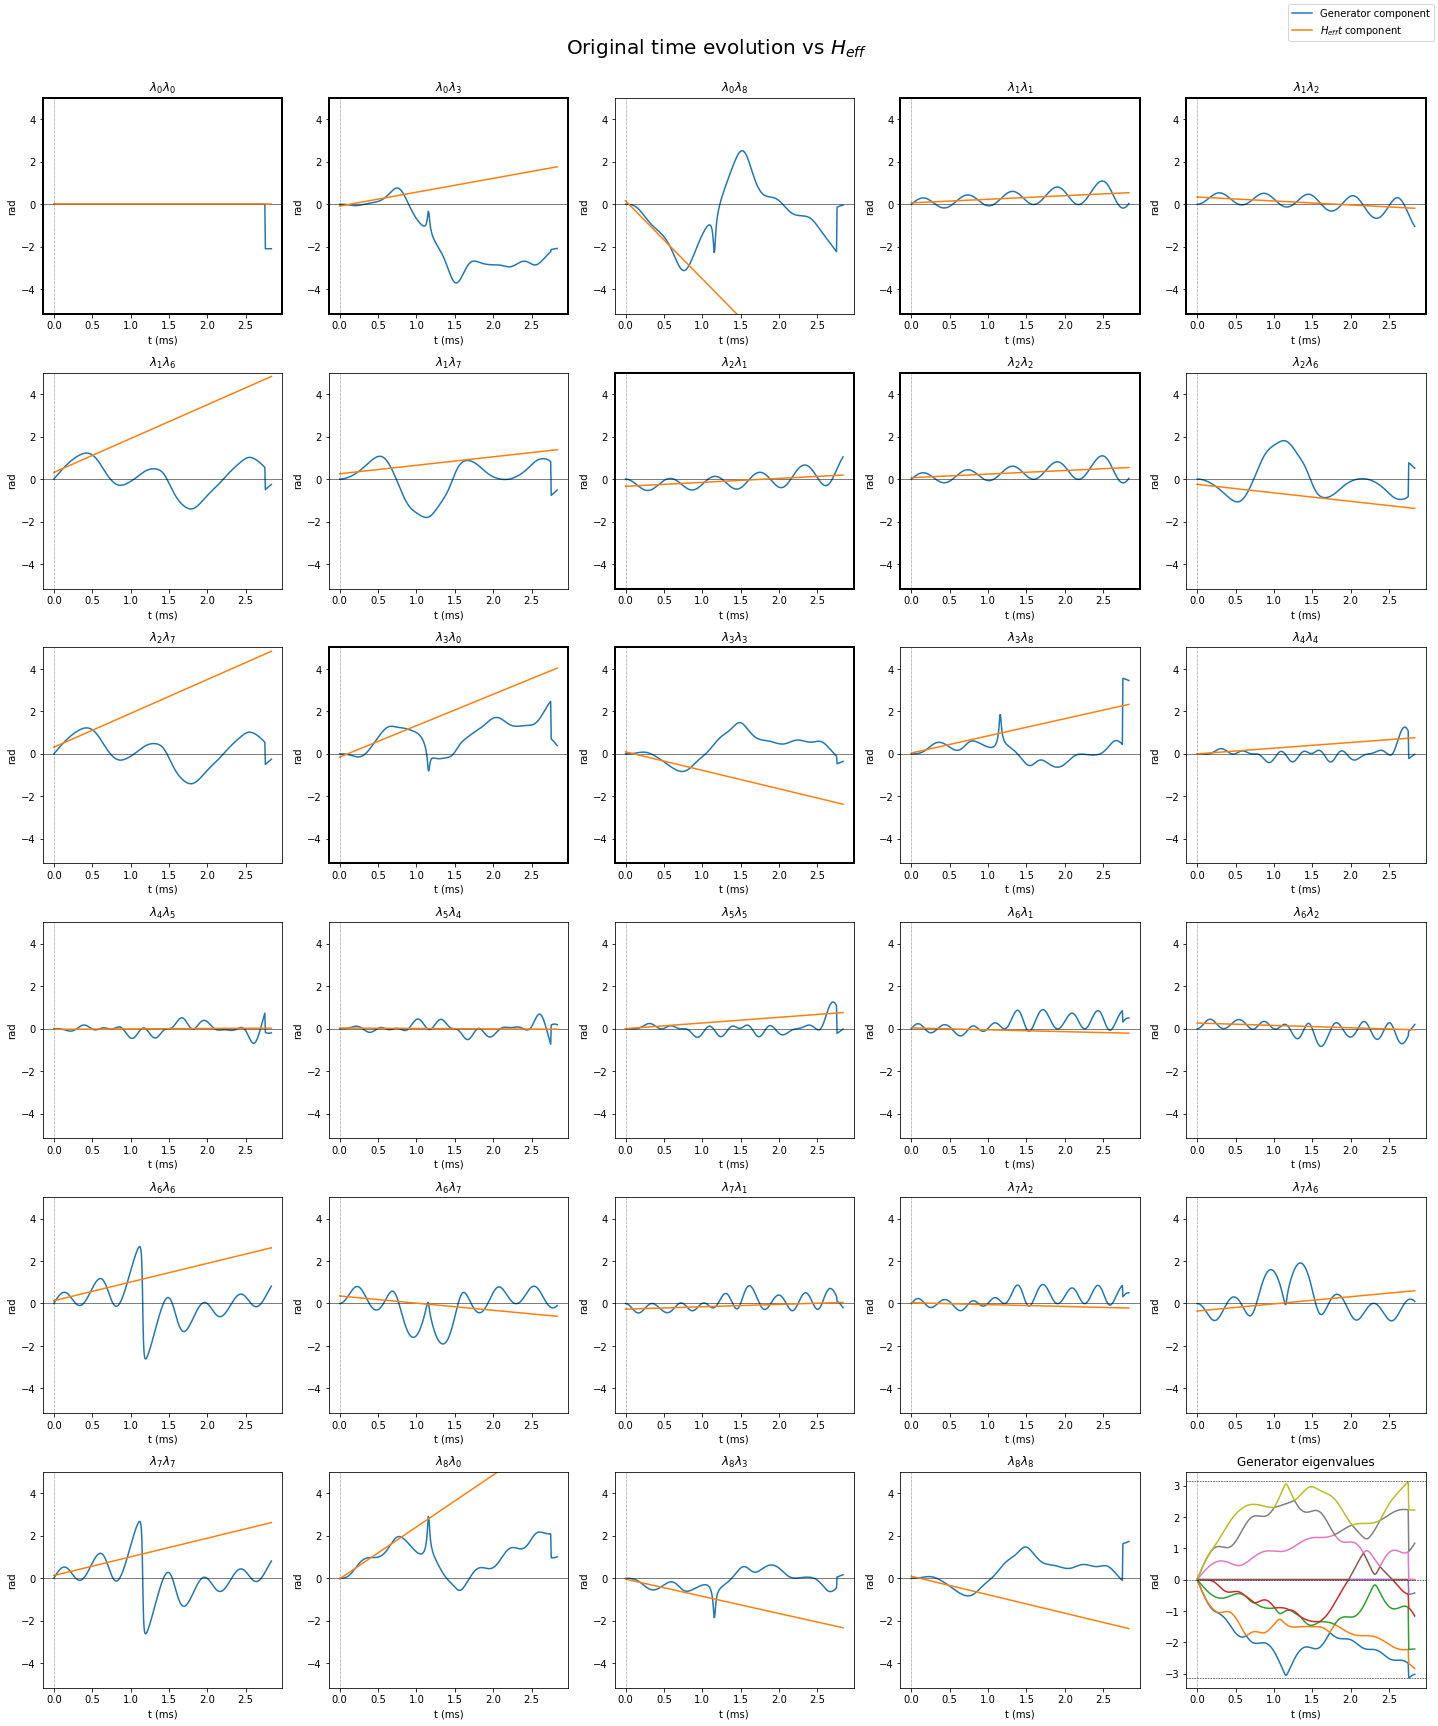

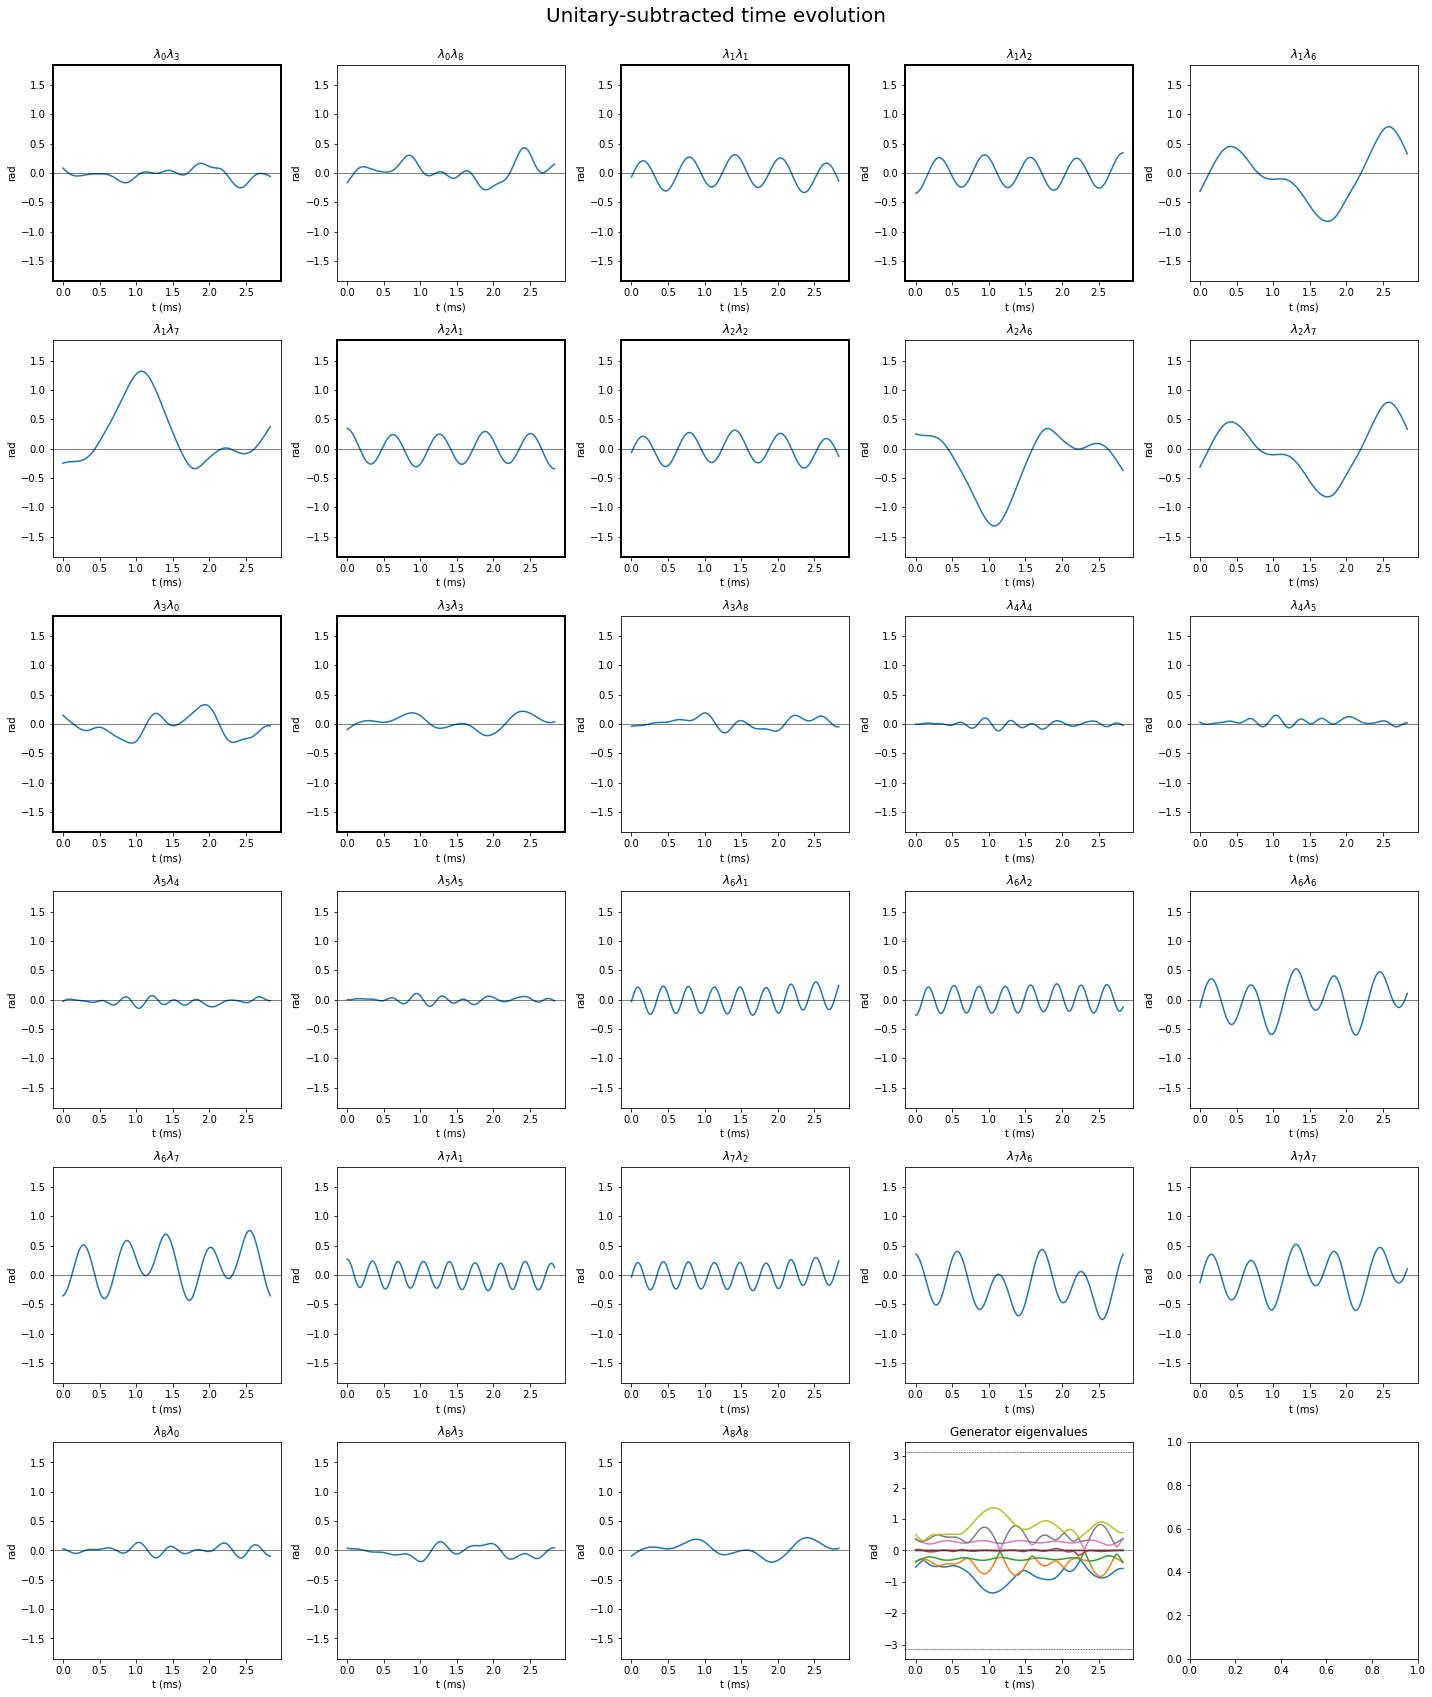

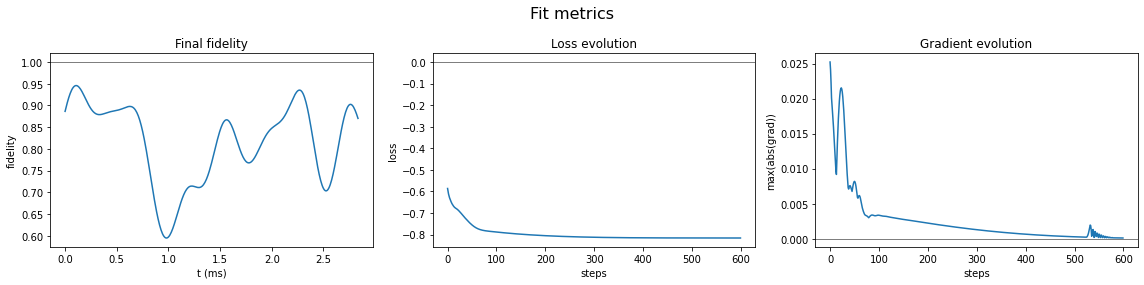

In [32]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/two_qutrit_hstat_quditframe.h5');